In [96]:
import dataclasses
from dataclasses import dataclass
from typing import Literal

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.collections
import matplotlib.lines
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from plotting import label_axes

# Fermi billiard

Fermi acceleration might be roughly modeled as a billiard-like interaction of two ball species:
large mass (moving plasma) and small mass (accelerated particles). Fermi acceleration in this case
is nothing more than the process thermalization between two unequal species, with heavy balls
transferring energy to light balls.

In [97]:
@dataclass
class BallParams:
    m: float
    r: float
    label: str
    color: str


def invert_along(v: np.ndarray, n: np.ndarray) -> np.ndarray:
    parallel = n * np.sum(v * n)
    perp = v - parallel
    return perp - parallel


@dataclass
class Ball:
    r: np.ndarray
    v: np.ndarray
    params: BallParams

    @property
    def E(self) -> float:
        return 0.5 * self.params.m * np.sum(self.v**2)

    def move(self, dt: float) -> None:
        self.r += self.v * dt

    def collide_wall(self, dimensions: np.ndarray) -> bool:
        multiplier = 1 - 2 * np.logical_or(
            np.logical_and(self.r < 0, self.v < 0),
            np.logical_and(self.r > dimensions, self.v > 0),
        )
        self.v *= multiplier
        return np.any(multiplier < 0)

    def plot_2d(self, ax: plt.Axes) -> None:
        ax.add_patch(
            matplotlib.patches.Circle(
                tuple(self.r), radius=self.params.r, color=self.params.color
            )
        )
        ax.add_patch(
            matplotlib.patches.Arrow(self.r[0], self.r[1], self.v[0], self.v[1])
        )

    def collide_ball(self, other: "Ball") -> bool:
        if self is other:
            return False
        o2s = self.r - other.r
        contact_dist = self.params.r + other.params.r
        distance = np.sqrt(np.sum(o2s**2))
        if distance > contact_dist:
            return False
        o2s /= distance
        v_com = (self.params.m * self.v + other.params.m * other.v) / (
            self.params.m + other.params.m
        )
        other_v_com = other.v - v_com
        if np.sum(other_v_com * o2s) < 0:  # balls are going away from each other
            return False
        # go to CoM -> invert component along o2s -> go back to LAB
        other.v = v_com + invert_along(other_v_com, o2s)
        self.v = v_com + invert_along(self.v - v_com, o2s)
        return True


def random_unit_vec(dim: int) -> np.ndarray:
    phi = np.random.random() * 2 * np.pi
    vx = np.cos(phi)
    vy = np.sin(phi)
    if dim == 2:
        return np.array([vx, vy])
    elif dim == 3:
        theta = np.arccos(np.random.random() * 2 - 1)
        vx *= np.sin(theta)
        vy *= np.sin(theta)
        vz = np.cos(theta)
        return np.array([vx, vy, vz])
    else:
        raise RuntimeError(f"Unsupported dim: {dim}")


@dataclass
class Billiard:
    dimensions: np.ndarray
    balls: list[Ball] = dataclasses.field(default_factory=list)

    n_coll_bw: int = 0
    n_coll_bb: int = 0

    def populate(self, params: BallParams, count: int, v: float) -> None:
        balls: list[Ball] = []
        for _ in range(count):
            balls.append(
                Ball(
                    r=(
                        params.r
                        + np.random.random(size=self.dimensions.size)
                        * (self.dimensions - 2 * params.r)
                    ),
                    v=v * random_unit_vec(dim=self.dimensions.size),
                    params=params,
                )
            )
        self.balls.extend(balls)

    def step(self, dt: float) -> None:
        for i, b in enumerate(self.balls):
            if b.collide_wall(self.dimensions):
                self.n_coll_bw += 1
            b.move(dt)
            for b2 in self.balls[(i + 1) :]:
                if b.collide_ball(b2):
                    self.n_coll_bb += 1

    def plot_2d(self, ax: plt.Axes) -> None:
        assert self.dimensions.size == 2
        labels = {b.params.label for b in self.balls}
        for label in labels:
            balls = [b for b in self.balls if b.params.label == label]
            circles = [
                matplotlib.patches.Circle(
                    tuple(b.r), radius=b.params.r, color=b.params.color
                )
                for b in balls
            ]
            coll = matplotlib.collections.PatchCollection(
                circles, color=balls[0].params.color
            )
            ax.add_collection(coll)

        ax.set_aspect("equal")
        ax.set_xlim(left=0, right=self.dimensions[0])
        ax.set_ylim(bottom=0, top=self.dimensions[1])

In [98]:
params = BallParams(m=1, r=0.51, label="", color="")
b1 = Ball(
    r=np.array([0, 0], dtype=float), v=np.array([1, 1], dtype=float), params=params
)
b2 = Ball(
    r=np.array([1, 0], dtype=float), v=np.array([-1, -1], dtype=float), params=params
)

# fig, ax = plt.subplots()
# ax.add_patch(
#             matplotlib.patches.Arrow(self.r[0], self.r[1], self.v[0], self.v[1])
#         )
# b2.plot_2d(ax)
# ax.set_xlim(-1, 2)
# ax.set_ylim(-1, 2)
# ax.set_aspect("equal")

print(b1.collide_ball(b2))

print(b1.v)
print(b2.v)

True
[-1.  1.]
[ 1. -1.]


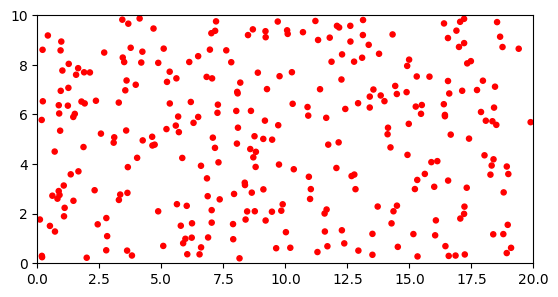

100%|██████████| 300/300 [00:34<00:00,  8.58it/s]

ball-ball collisions: 345
ball-wall collisions: 87


In [99]:
billiard = Billiard(dimensions=np.array([20, 10]))
count = 300
params = BallParams(m=1, r=np.sqrt(0.05 * np.prod(billiard.dimensions) / (count * np.pi)), label="ball", color="red")
v_init = 1
billiard.populate(
    params=params,
    count=count,
    v=v_init,
)

_, ax = plt.subplots()
billiard.plot_2d(ax)
plt.show()

# trajectories = [[] for _ in billiard.balls]
E_samples = []
n_samples = 5

dt = 0.01
T = 3
n_steps = int(T / dt)
sample_each = n_steps // n_samples
for i in trange(n_steps):
    if i % sample_each == 0:
        E_samples.append(np.array([b.E for b in billiard.balls]))
    billiard.step(dt)

print("ball-ball collisions:", billiard.n_coll_bb)
print("ball-wall collisions:", billiard.n_coll_bw)

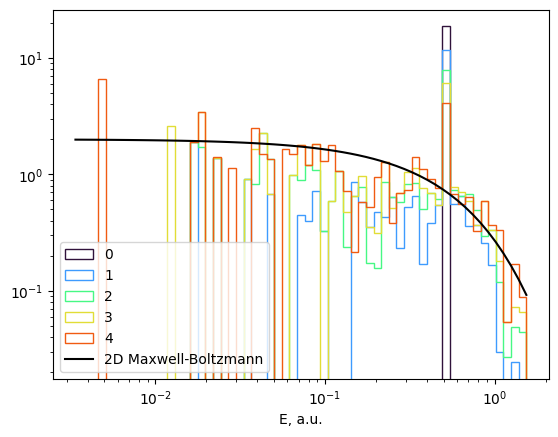

In [100]:
fig, ax = plt.subplots()

E_avg = params.m * v_init**2 / 2

E_min = min(sample.min() for sample in E_samples)
E_max = max(sample.max() for sample in E_samples)
E_bins = np.logspace(np.log10(E_min), np.log10(E_max), 60)
cmap = matplotlib.colormaps["turbo"]
for idx, sample in enumerate(E_samples):
    color = cmap(idx / len(E_samples))
    ax.hist(
        sample, density=True, histtype="step", bins=E_bins, label=str(idx), color=color
    )

E_grid = E_bins
ax.plot(E_grid, np.exp(-E_grid / E_avg) / E_avg, color="k", label="2D Maxwell-Boltzmann")
ax.set_xlabel("E, a.u.")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()